## Attention is All You Need

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

import warnings
warnings.simplefilter('ignore')

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import spacy.cli 
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
# Creating tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens)
    
    :param text: the german sentence
    """
    
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    
    :param text: the english sentence
    """
    
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
# Source is in German and Target is in English

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

In [7]:
# Download and load the train, valid and test data

train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.de', '.en'),
    fields = (SRC, TRG)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 414kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [8]:
# Verifying

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [9]:
# building vocabulary
# min_freq => min threshold to include the word in the vocab

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
# Unique Tokens
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


## Creating Iterators

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## Building the Model

### Encoder

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        """
        :param input_dim: It is the size/dimensionality of the one-hot vectors that will be input to the encoder. 
                        This is equal to the input (source) vocabulary size.
        :param hid_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with hid_dim dimensions.
        :param n_layers: The number of (Attention) layers stacked in the Encoder.
        :param n_heads: The number of heads in the Multi-Head Attention Layer.
        :param pf_dim: In Feed Forward Network, hid_dim is first converted to pf_dim.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: cpu or gpu
        :param max_length: the maximum length of the sentence upto which transformer can work properly.
        """
        
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([
            EncoderLayer(
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device
            )
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        """
        :param src: the source sentence
                    src.shape => (batch_size, src_len)
        :param src_mask: Its corresponding mask
                    src_mask.shape => (batch_size, 1, 1, src_len)
        """
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos.shape => (batch_size, src_len)
        
        src = self.dropout(
            (self.tok_embedding(src) * self.scale) +
            self.pos_embedding(pos)
        )
        # src.shape => (batch_size, src_len, hid_dim)
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        # src.shape => (batch_size, src_len, hid_dim)
        
        return src

### Encoder Layer

In [13]:
class EncoderLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        """
        :param hid_dim: It is the dimensionality of the embedding layer.
        :param n_heads: The number of heads in the Multi-Head Attention Layer.
        :param pf_dim: In Feed Forward Network, hid_dim is first converted to pf_dim.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: cpu or gpu
        """
        
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        # This is just, y = {(x - E(x)) / (Var(x) + e)**0.5} * gamma + beta
        # gamma and beta are learned
        
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, src, src_mask,):
        """
        :param src: the source sentence
                    src.shape => (batch_size, src_len)
        :param src_mask: Its corresponding mask
                    src_mask.shape => (batch_size, 1, 1, src_len)
        """
        
        # self Attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src.shape => (batch_size, src_len, hid_dim)
        
        # Positionwise Feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src.shape => (batch_size, src_len, hid_dim)
        
        return src

### Multi-Head Attention Layer

In [14]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        """
        :param hid_dim: It is the dimensionality of the embedding layer.
        :param n_heads: The number of heads in the Multi-Head Attention Layer.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: cpu or gpu
        """
        
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        """
        :param query: the vector to feed in the `QUERY` linear layer.
                      query.shape => (batch_size, query_len, hid_dim)
        :param key: the vector to feed in the `KEY` linear layer.
                      key.shape => (batch_size, key_len, hid_dim)
        :param value: the vector to feed in the `VALUE` linear layer.
                      value.shape => (batch_size, value_len, hid_dim)
        :param mask: to mask the non significant values with -ve INF
        """
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q.shape => (batch_size, query_len, hid_dim)
        # K.shape => (batch_size, key_len, hid_dim)
        # V.shape => (batch_size, value_len, hid_dim)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q.shape => (batch_size, n_heads, query_len, head_dim)
        # K.shape => (batch_size, n_heads, key_len, head_dim)
        # V.shape => (batch_size, n_heads, value_len, head_dim)
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy.shape => (batch_size, n_heads, query_len, key_len)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention.shape => (batch_size, n_heads, query_len, key_len)
        
        x = torch.matmul(self.dropout(attention), V)
        # x.shape => (batch_size, n_heads, query_len, head_dim)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x.shape => (batch_size, query_len, n_heads, head_dim)
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x.shape => (batch_size, query_len, hid_dim)
        
        x = self.fc_o(x)
        # x.shape => (batch_size, query_len, hid_dim)
        
        return x, attention

### Positionwise Feedforward Layer

In [15]:
class PositionwiseFeedforwardLayer(nn.Module):
    
    def __init__(self, hid_dim, pf_dim, dropout):
        """
        :param hid_dim: It is the dimensionality of the embedding layer.
        :param pf_dim: In Feed Forward Network, hid_dim is first converted to pf_dim.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        """
        
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        :param x: input to Positionwise-Feedforward-Layer
                x.shape => (batch_size, seq_len, hid_dim)
        """
        
        # In the paper, they used GELU activation function
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x.shape => (batch_size, seq_len, pf_dim)
        
        x = self.fc_2(x)
        # x.shape => (batch_size, seq_len, hid_dim)
        
        return x

### Decoder

In [16]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        """
        :param output_dim: It is the size/dimensionality of the one-hot vectors that will be input to the decoder. 
                        This is equal to the output (target) vocabulary size.
        :param hid_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with hid_dim dimensions.
        :param n_layers: The number of (Attention) layers stacked in the Decoder.
        :param n_heads: The number of heads in the Multi-Head Attention Layer.
        :param pf_dim: In Feed Forward Network, hid_dim is first converted to pf_dim.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: cpu or gpu
        :param max_length: the maximum length of the sentence upto which transformer can work properly.
        """
        
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([
            DecoderLayer(
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device
            )
            for _ in range(n_layers)
        ])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        :param trg: the target sentence
                    trg.shape => (batch_size, trg_len)
        :param enc_src: the encoded source sentence
                    enc_src.shape => (batch_size, src_len, hid_dim)
        :param trg_mask: the mask for the target sentence
                    trg_mask.shape => (batch_size, 1, trg_len, trg_len)
                    As we are processing all of the target tokens at once in parallel,
                    we need a method of stopping the decoder from "cheating" by simply "looking"
                    at what the next token in the target sequence is and outputting it.
        :param src_mask: the mask for the source sentence
                    src_mask.shape => (batch_size, 1, 1, src_len)
        """
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos.shape => (batch_size, trg_len)
        
        trg = self.dropout(
            (self.tok_embedding(trg) * self.scale) + 
            self.pos_embedding(pos)
        )
        # trg.shape => (batch_size, trg_len, hid_dim)
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # trg.shape => (batch_size, trg_len, hid_dim)
        # attention.shape => (batch_size, n_heads, trg_len, src_len)
        
        output = self.fc_out(trg)
        # output.shape => (batch_size, trg_len, output_dim)
        
        return output, attention

### Decoder Layer

In [17]:
class DecoderLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        """
        :param hid_dim: It is the dimensionality of the embedding layer.
        :param n_heads: The number of heads in the Multi-Head Attention Layer.
        :param pf_dim: In Feed Forward Network, hid_dim is first converted to pf_dim.
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param device: cpu or gpu
        """
        
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        self.postionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        :param trg: the target sentence
                    trg.shape => (batch_size, trg_len)
        :param enc_src: the encoded source sentence
                    enc_src.shape => (batch_size, src_len, hid_dim)
        :param trg_mask: the mask for the target sentence
                    trg_mask.shape => (batch_size, 1, trg_len, trg_len)
        :param src_mask: the mask for the source sentence
                    src_mask.shape => (batch_size, 1, 1, src_len)
        """
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg.shape => (batch_size, trg_len, hid_dim)
        
        # Encoder Attention
        # Query = trg
        # Key and Value = enc_src, i.e from encoder
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # attention.shape => (batch_size, n_heads, trg_len, src_len)
        
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg.shape => (batch_size, trg_len, hid_dim)
        
        # positionwise feedforward
        _trg = self.postionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg.shape => (batch_size, trg_len, hid_dim)
        
        return trg, attention

### Seq2Seq Model

In [18]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        """
        :param encoder: the encoder of the transformer
        :param decoder: the decoder of the transformer
        :param src_pad_idx: the <pad> index for the source sentence
        :param trg_pad_idx: the <pad> index for the target sentence
        :param device" cpu or gpu
        """
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        """
            make the mask for source sentences
            
        :param src: the source sentence
                    src.shape => (batch_size, src_len)
        """
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask.shape => (batch_size, 1, 1, src_len)
        
        return src_mask
    
    def make_trg_mask(self, trg):
        """
            make the mask for the target sentence
            
        :param trg: the target sentence
                    trg.shape => (batch_size, trg_len)
        """
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_idx.shape => (batch_size, 1, 1, trg_len)
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril( # lower triangular matrix
            torch.ones(
                (trg_len, trg_len),
                device = self.device
            )
        ).bool()
        # trg_sub_mask.shape => (trg_len, trg_len)
        
        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask.shape => (batch_size, 1, trg_len, trg_len)
        
        return trg_mask
    
    def forward(self, src, trg):
        """
        :param src: the source sentence
                    src.shape => (batch_size, src_len)
        :param trg: the target sentence
                    trg.shape => (batch_size, trg_len)
        """
        
        src_mask = self.make_src_mask(src)
        # src_mask.shape => (batch_size, 1, 1, src_len)
        
        trg_mask = self.make_trg_mask(trg)
        # trg_mask.shape => (batch_size, 1, trg_len, trg_len)
        
        enc_src = self.encoder(src, src_mask)
        # enc_src.shape => (batch_size, src_len, hid_dim)
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output.shape => (batch_size, trg_len, output_dim)
        # attention.shape => (batch_size, n_heads, trg_len, src_len)
        
        return output, attention

## Training the Seq2Seq Model

## Init the Model

In [19]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [20]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [22]:
def initialize_weights(m):
    """
        Initializing weights using Xavier Uniform distribution.
        (common for transformer models)
    """
    
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

## Training Function

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        # output.shape => (batch size, trg len - 1, output dim)
        # trg.shape => (batch size, trg len)
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        # output.shape => (batch size * trg len - 1, output dim)
        # trg.shape => (batch size * trg len - 1)
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Evaluate Function

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            # output.shape => (batch size, trg len - 1, output dim)
            # trg.shape => (batch size, trg len)
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            # output.shape => (batch size * trg len - 1, output dim)
            # trg.shape => (batch size * trg len - 1)
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.221 | Train PPL:  68.072
	 Val. Loss: 3.018 |  Val. PPL:  20.442
Epoch: 02 | Time: 0m 15s
	Train Loss: 2.811 | Train PPL:  16.630
	 Val. Loss: 2.295 |  Val. PPL:   9.929
Epoch: 03 | Time: 0m 15s
	Train Loss: 2.235 | Train PPL:   9.351
	 Val. Loss: 1.979 |  Val. PPL:   7.234
Epoch: 04 | Time: 0m 15s
	Train Loss: 1.884 | Train PPL:   6.582
	 Val. Loss: 1.804 |  Val. PPL:   6.076
Epoch: 05 | Time: 0m 15s
	Train Loss: 1.636 | Train PPL:   5.135
	 Val. Loss: 1.708 |  Val. PPL:   5.516
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.448 | Train PPL:   4.253
	 Val. Loss: 1.668 |  Val. PPL:   5.303
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.295 | Train PPL:   3.651
	 Val. Loss: 1.630 |  Val. PPL:   5.102
Epoch: 08 | Time: 0m 15s
	Train Loss: 1.169 | Train PPL:   3.218
	 Val. Loss: 1.622 |  Val. PPL:   5.062
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.059 | Train PPL:   2.882
	 Val. Loss: 1.634 |  Val. PPL:   5.126
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.965 | Train PPL

In [30]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.676 | Test PPL:   5.342 |


## Inference

In [31]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    """
        translate the given `sentence` in src lang to the trg lang.
    
    :param sentence: the sentence string in src lang
    :param src_field: the SRC Field object
    :param trg_field: the TRG Field object
    :param model: the Seq2Seq model
    :param device: gpu or cpu
    :param max_len: the maximum length permitted for the trg sentence
    """
    model.eval()
    
    # Sentence --> tokens
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    # adding <sos> and <eos>
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    # Tokens --> list of indices, acc. to SRC vocab 
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor.shape => (1, src_len), where 1 = batch_size
    
    src_mask = model.make_src_mask(src_tensor)
    # src_mask.shape => (batch_size = 1, 1, 1 ,src_len)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        # trg_tensor.shape => (1, `i+1`)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        # trg_mask.shape => (batch_size = 1, 1, `i+1`, `i+1`)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            # output.shape => (batch_size = 1, `i+1`, output_dim)
            # attention.shape => (batch_size = 1, n_heads, `i+1`, src_len)
        
        pred_token = output.argmax(2)[:,-1].item()
        # output.shape => (batch_size, trg_len so far = `i + 1` , hid_dim)
        # argmax on 2nd dimension
        # o/p = max prob. token for each token
        # i.e j = 0th pos to .... to j = ith pos
        # but we just want the last token, to feed in, for the next iteration
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention


In [32]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [33]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [34]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


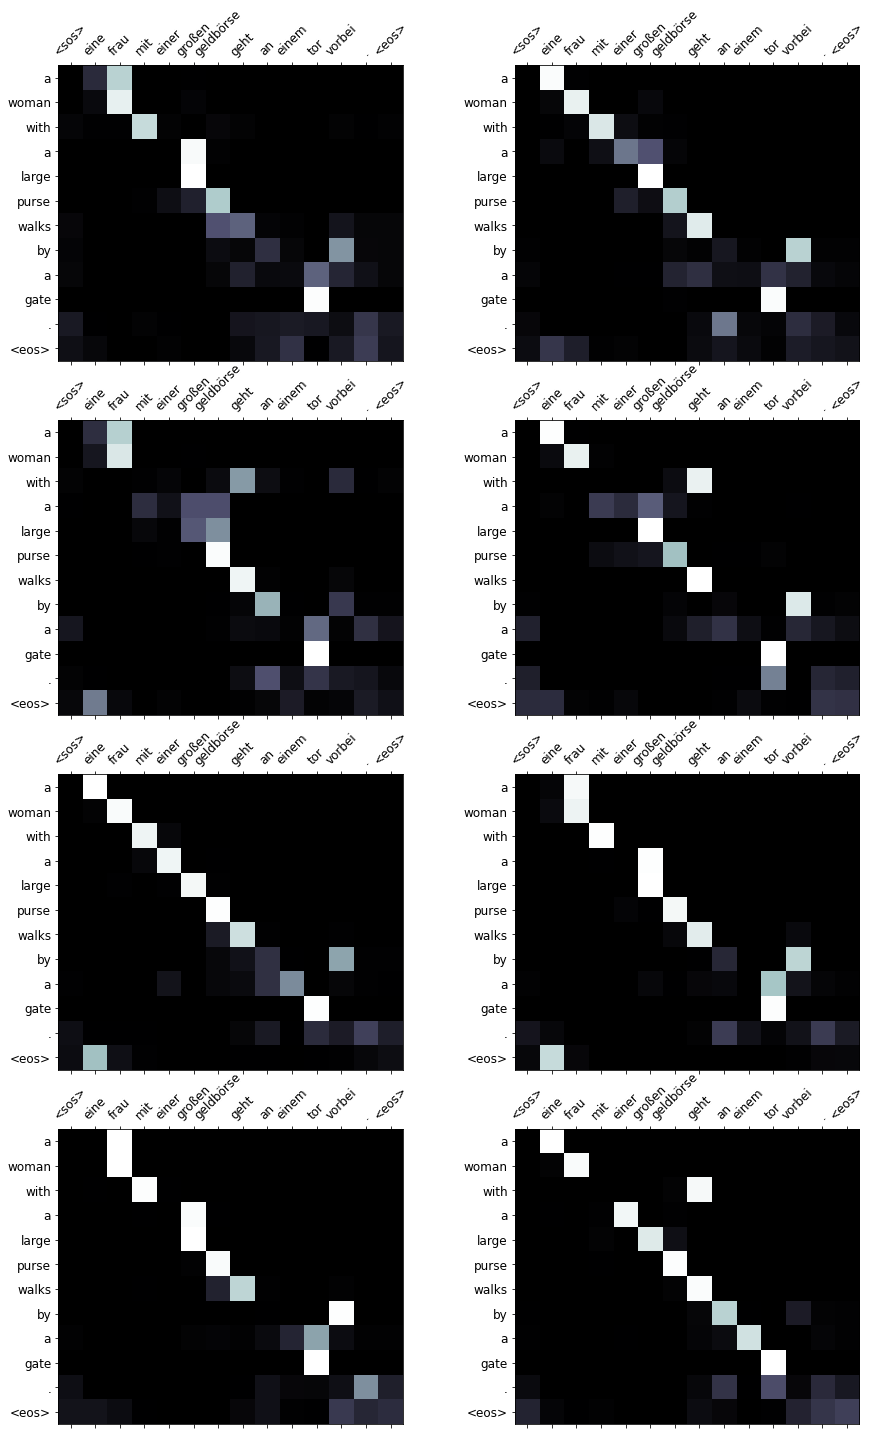

In [35]:
display_attention(src, translation, attention)

In [36]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [37]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


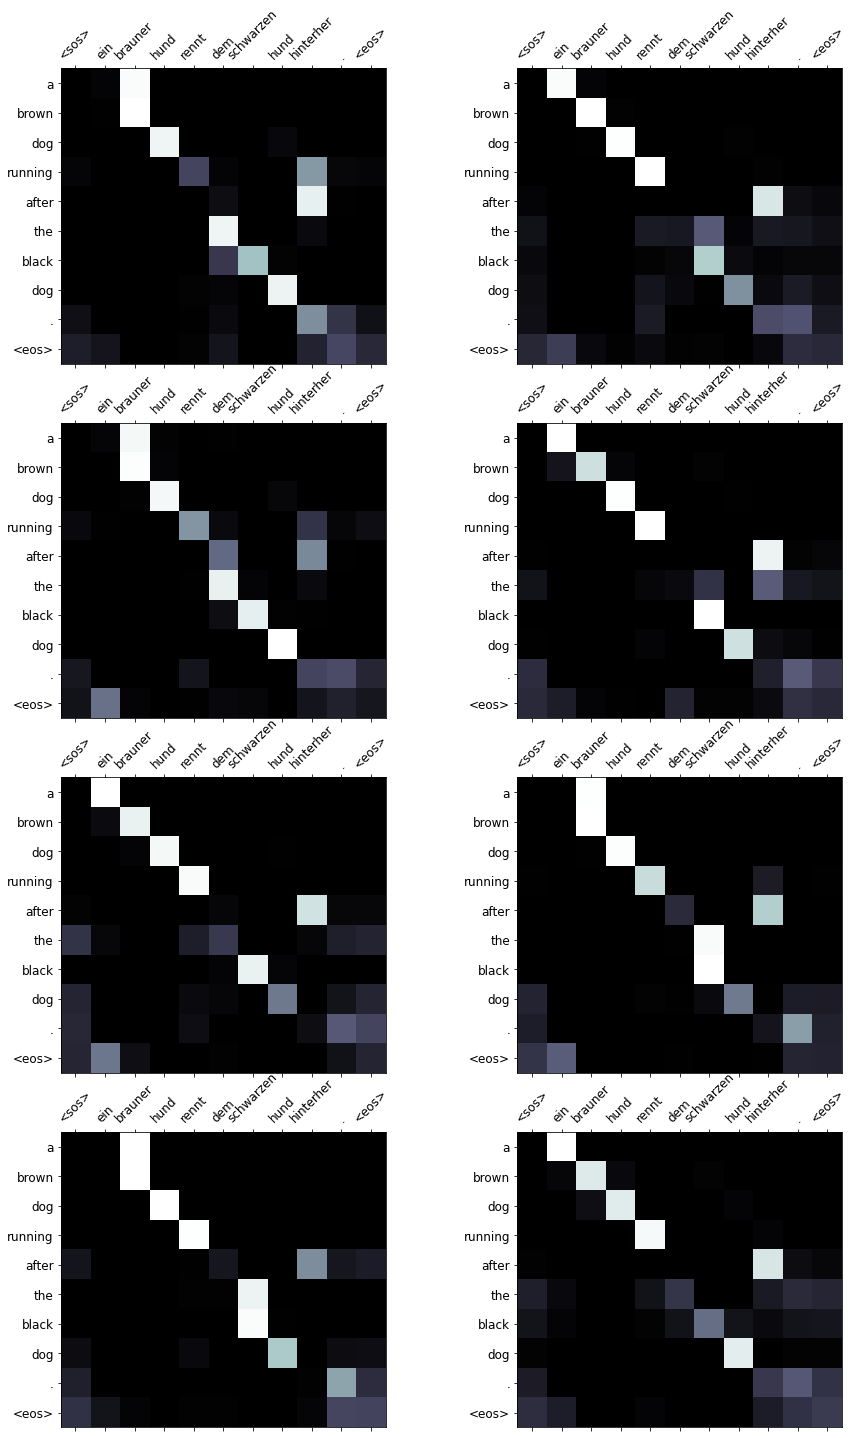

In [38]:
display_attention(src, translation, attention)

## BLEU Score

In [39]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [40]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.85
